# Pulse arrival times from the Crab pulsar

In [39]:
import os
import numpy as np
from __future__ import (division, absolute_import, print_function)
from scipy import interpolate

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.time import Time

from  matplotlib import pyplot as plt
import matplotlib

from math import pi

%matplotlib inline

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

## 1. Reading the input data

The ToAs are recorded as a time value in [Modified Julian Date](http://tycho.usno.navy.mil/mjd.html) (MJD). The error is recorded in microseconds.

The barytable has six columns: Firstly the year, month, day number, followed by x, y, z components of the vector in [astronomical units](https://en.wikipedia.org/wiki/Astronomical_unit). This table should be for the year your observations are recorded.

In [2]:
# Get the data directory path
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "DataSP")

barytable_dir = os.path.join(data_dir, "BaryTables")
toa_dir = os.path.join(data_dir, "TOAs")
period_dir = os.path.join(data_dir, "PeriodEstimates")

# Functions for reading data
# --------------------------
def load_barytable(file_name):
    """
    Load the barytable file.
    
    @param file_name :: name of the file containing barytable data
    
    @returns :: arrays with year, month, day, xpos, ypos, zpos
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(barytable_dir, file_name)
    barytable = np.loadtxt(data_file, unpack=True)
    
    return barytable

def load_toas(file_name):
    """
    Load the time of arrivals from file.
    
    @param file_name :: name of the file containing barytable data
    
    @returns :: array containing time of arrival
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(toa_dir, file_name)
    toas = np.loadtxt(data_file, usecols=(2,3))
    
    return toas
    
def read_pest(file_name):
    """
    Read the period estimate form file.
    
    @param file_name :: name of the file containing barytable data
    
    @returns :: float with the period estimate
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(period_dir, file_name)
    with open(data_file) as dfile:
        line = dfile.read()
        
    period = float(line[23:-8])
    
    return period

In [4]:
# Crab 1 data
crab1_barytable = load_barytable('Crab1Barytable')
crab1_toas = load_toas('Crab1ToAs')
crab1_pest = read_pest('Crab1TEst')

## 2. Interpolation of Barycenter


In [47]:
def compose_date(years, months=1, days=1,
                 hours=None, minutes=None, seconds=None,
                 milliseconds=None):
    """
    Converts array of years, months etc. into numpy64 date array.
    
    @param years :: array of years corresponding to each date
    @param months :: array of months corresponding to each date
    @param days :: array of days corresponding to each date
    @param hours :: array of hours corresponding to each date
    @param minutes :: array of minutes corresponding to each date
    @param seconds :: array of seconds corresponding to each date
    
    @returns :: array of numpy64date format dates
    """
    
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]')
    vals = (years, months, days, hours, minutes, seconds, milliseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def mjd_convert(raw_data):
    """
    Converts normal dates from psrchive to modified julian dates.
    
    @param raw_data :: raw array of year, month, day as read from
                       the data file on the barycentre
                       
    @returns :: modified julian date format times
    """
    
    dates = raw_data[:3]
    midnights = np.zeros((4,len(dates[0])))
    times_raw = np.concatenate((dates,midnights))
    times = compose_date(times_raw[0], times_raw[1], times_raw[2],
                         times_raw[3], times_raw[4], times_raw[5],
                         times_raw[6])
    converted_times =  Time(times.astype('string').tolist(), 
                            format='isot', scale='utc')
    mjd_times = converted_times.mjd
    
    return mjd_times

def bary_distance(raw_data):
    """
    Computes the distance from the barycenter to Earth
    on a particular day at a particular time.
    
    @param raw_data :: raw array of year, month, day as read from
                       the data file on the barycentre
                       
    @returns :: magnitude of the x,y,z vector from the raw data
    """
    
    xyz = np.transpose(raw_data[3:])
    dist = np.zeros(len(xyz))
    for i, vect in enumerate(xyz):
        dist[i] += np.sqrt(vect[0]**2 + vect[1]**2 + vect[2]**2)
    
    return dist

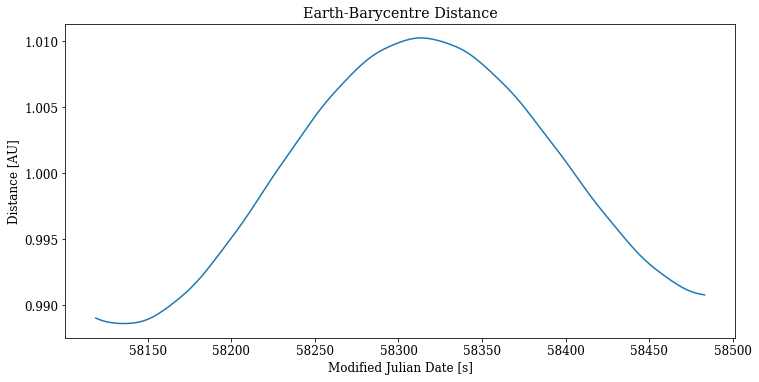

In [57]:
# Plot barycenter data
mjd_times = mjd_convert(crab1_barytable)
distances = bary_distance(crab1_barytable)

plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(mjd_times, distances)
plt.xlabel("Modified Julian Date [s]")
plt.ylabel("Distance [AU]")
plt.title("Earth-Barycentre Distance")
plt.subplots_adjust(bottom=0.1, top=0.9)

In [58]:
def lag_interpolate(time, n):
    """
    Performs a lagrangian interpolate of order n
    to more accurately determine the Earth-Bary distance at
    a specific time.
    
    @param time :: desired time for which the distance should
                   be calculated
    @param n :: order of the lagrangian interpolate to be calculated
    
    @returns :: the distance at the specified time and the error on it
    """
    idxs = np.where(np.logical_and(mjd_convert <= time + n/2,
                                   mjd_convert >= time - n/2))
    
    xvals = mjd_times[idxs]
    yvals = distances[idxs]
    
    interp = interpolate.lagrange(xvals, yvals)
    return interp(times)

## 3. Compute the Earth delay

The following libraries have been imported for your convinience:
 * ``astropy.coordinate`` has been imported as ``coord``
 * ``astropy.time`` has been imported as ``astrotime``
 

In [ ]:
# Insert the position of the crab pulsar here!
pulsarpos = coord.SkyCoord(ra="01:23:45.6",dec="12:34:56.7",unit=(u.hourangle,u.deg))

#lovellpos = coord.EarthLocation(...)

#times = astrotime.Time(...)

# To compute the angle between the pulsar and the earth we can use astropy to tell us the elevation angle to the pulsar.
# First Transform the coordinate system to an Alt-Az system. This needs the location of the telescope and the times
# of the observation.
# altaz = pulsarpos.transform_to(coord.AltAz(obstime=times,location=lovellpos))


# earth_delay = ...

## Compute the Roemer delay

This is the delay corresponding to the distance of the centre of the Earth to the barycentre.


In [ ]:
# psr_x = ...
# psr_y = ...
# psr_z = ...

# roemer_delay = ...

## Residuals from a fixed period model



In [ ]:
#Find out a suitable guess period for your dataset using the instructions in the lab script
period_guess = XXXX 


# residual = 

# Do fitting (try the polyfit routine in numpy)